In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import reciprocalspaceship as rs
import scipy.optimize as opt
import gemmi as gm
from tqdm import tqdm
from pathlib import Path
import os

import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

In [2]:
from xtal_analysis.xtal_analysis_functions import load_ccp4, solvent_mask, make_Nbg_map, save_Nbg_map
from xtal_analysis.xtal_analysis_functions import get_mapmask, CC_vs_n_2FoFc
from xtal_analysis.params import *

#### Specify all parameters :

In [3]:
min_fraction = 1e-6
max_fraction = 1.0 
increment    = 0.01
sampling     = 0.35

#### (1) Load in light and dark 2mFo-DFc maps and apply solvent mask (in case not already applied)

In [4]:
off_m, off_g, off_a, off = load_ccp4('{path}/input_maps/neg5ps-400nm_nochrom_2mFo-DFc_map.ccp4'.format(path=loop_path))
on_m,  on_g,  on_a, on   = load_ccp4('{path}/input_maps/{name}_nochrom_2mFo-DFc_map.ccp4'.format(path=loop_path, name=name))
on_nosolv                = solvent_mask(pdb_path, sampling, on_a)
off_nosolv               = solvent_mask(pdb_path, sampling, off_a)

In [5]:
on_g

<gemmi.FloatGrid(150, 180, 216)>

#### (2) Create chromophore mask

In [6]:
mask = get_mapmask(on_g, chrom_center, chrom_radius)
masked_array = on_nosolv.reshape(grid_size[0],grid_size[1],grid_size[2])*mask
masked_array = np.nan_to_num(masked_array)

#### (3) Compute correlation between ON and N$_\mathrm{bg}$ OFF maps for different N$_\mathrm{bg}$s

In [7]:
fractions = np.arange(min_fraction, max_fraction+increment, increment)

In [8]:
chrom    = masked_array.flatten().astype(bool)
CCs_loc  = CC_vs_n_2FoFc(on_nosolv[chrom], off_nosolv[chrom], fractions)
CCs_glob = CC_vs_n_2FoFc(on_nosolv[np.logical_not(chrom)], off_nosolv[np.logical_not(chrom)], fractions)
diffs    = np.array(CCs_glob) -  np.array(CCs_loc)

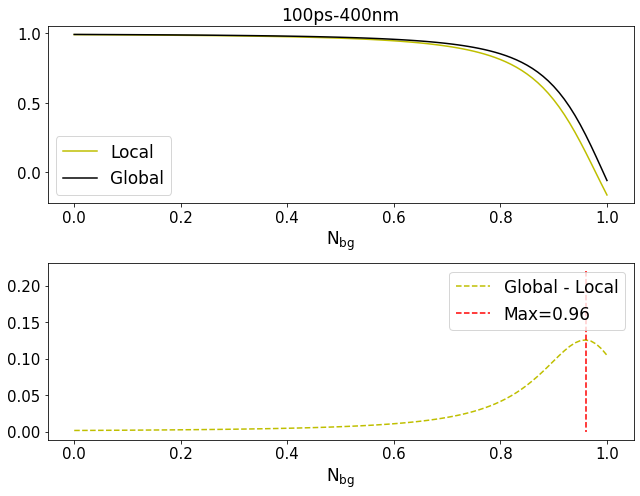

In [9]:
fig, ax = plt.subplots(2,1, figsize=(9,7))

ax[0].plot(fractions, CCs_loc, 'y', label='Local')
ax[0].plot(fractions, CCs_glob, 'k', label='Global')
ax[1].plot(fractions, np.array(CCs_glob)-np.array(CCs_loc), 'y', linestyle= 'dashed', label='Global - Local')
ax[1].vlines(fractions[np.argmax(diffs)], 0.22, 0, 'r', linestyle= 'dashed', linewidth=1.5, label='Max={}'.format(np.round(fractions[np.argmax(diffs)], decimals=3)))

ax[0].set_title('{}'.format(name), fontsize=17)
ax[0].set_xlabel('N$_{\mathrm{bg}}$', fontsize=17)
ax[1].set_xlabel('N$_{\mathrm{bg}}$', fontsize=17)
ax[0].legend(fontsize=17)
ax[1].legend(fontsize=17)

plt.tight_layout()
plt.show()

#### (4) Save map from maximized N$_\mathrm{bg}$ in CCP4 format

In [10]:
Nbg_max = fractions[np.argmax(diffs)]
map_max = make_Nbg_map(on_a, off_a, Nbg_max)

In [11]:
save_Nbg_map(map_max, Nbg_max, loop_path, name)

5832000it [00:50, 115949.98it/s]


#### (5) Tidy up! Move all generated files to new folder

In [12]:
Path("Nbg_loop_2Fo-Fc/{}".format(name)).mkdir(parents=True, exist_ok=True)
os.system("mv {name}_2mFo-DFc* Nbg_loop_2Fo-Fc/{name}/".format(name=name))

0